In [2]:
import sqlite3
import pandas as pd
import seaborn as sns

In [3]:
conn = sqlite3.connect('/Users/aaronlevi/Documents/sql_db/chords_list.db')
cur = conn.cursor()

In [4]:
# df = pd.read_sql_query("SELECT * FROM basic_info", conn)

# dfb_test = pd.read_sql_query("SELECT Artist, Song FROM basic_info", conn)
# dfb_test

# X = pd.read_sql_query("SELECT * FROM features", conn)
# y = pd.read_sql_query("SELECT label FROM basic_info", conn)

allFeatures = pd.read_sql_query("SELECT * FROM features", conn)
labels = pd.read_sql_query("SELECT label FROM basic_info", conn)

# allFeatures = allFeatures.iloc[57:].reset_index(drop=True)
# allFeatures.drop('index', axis=1, inplace=True)

# labels = labels.iloc[57:].reset_index(drop=True)
allFeatures = allFeatures.iloc[57:1329].reset_index(drop=True)
allFeatures.drop('index', axis=1, inplace=True)

labels = labels.iloc[57:1329].reset_index(drop=True)

In [5]:
dummyLabel=pd.get_dummies(labels)
dummyLabel.head()

,Label_advanced,Label_intermediate,Label_novice
0,0,0,1
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


In [6]:
# making a few df's for ease of plotting... kinda clunky
featuresWithLabels = pd.concat([allFeatures, dummyLabel], axis=1, sort=False)
featuresWithLabels.dropna(axis=0, how='any', inplace=True)

featuresNovice = pd.concat([allFeatures, dummyLabel['Label_novice']], axis=1, sort=False)
featuresWithLabels.dropna(axis=0, how='any', inplace=True)

featuresInter = pd.concat([allFeatures, dummyLabel['Label_intermediate']], axis=1, sort=False)
featuresWithLabels.dropna(axis=0, how='any', inplace=True)

featuresAdv = pd.concat([allFeatures, dummyLabel['Label_advanced']], axis=1, sort=False)
featuresWithLabels.dropna(axis=0, how='any', inplace=True)
featuresAdv.head()

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min,Label_advanced
0,172.286,3.533967,4.0,0.292,3,0,0.848904,0
1,96.996,1.981967,4.0,0.771,12,12,6.054592,1
2,75.646,5.499333,4.0,0.223,5,1,0.909201,1
3,120.042,3.588000,4.0,0.762,6,4,1.672241,0
4,150.190,5.052000,4.0,0.558,8,4,1.583531,0


//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


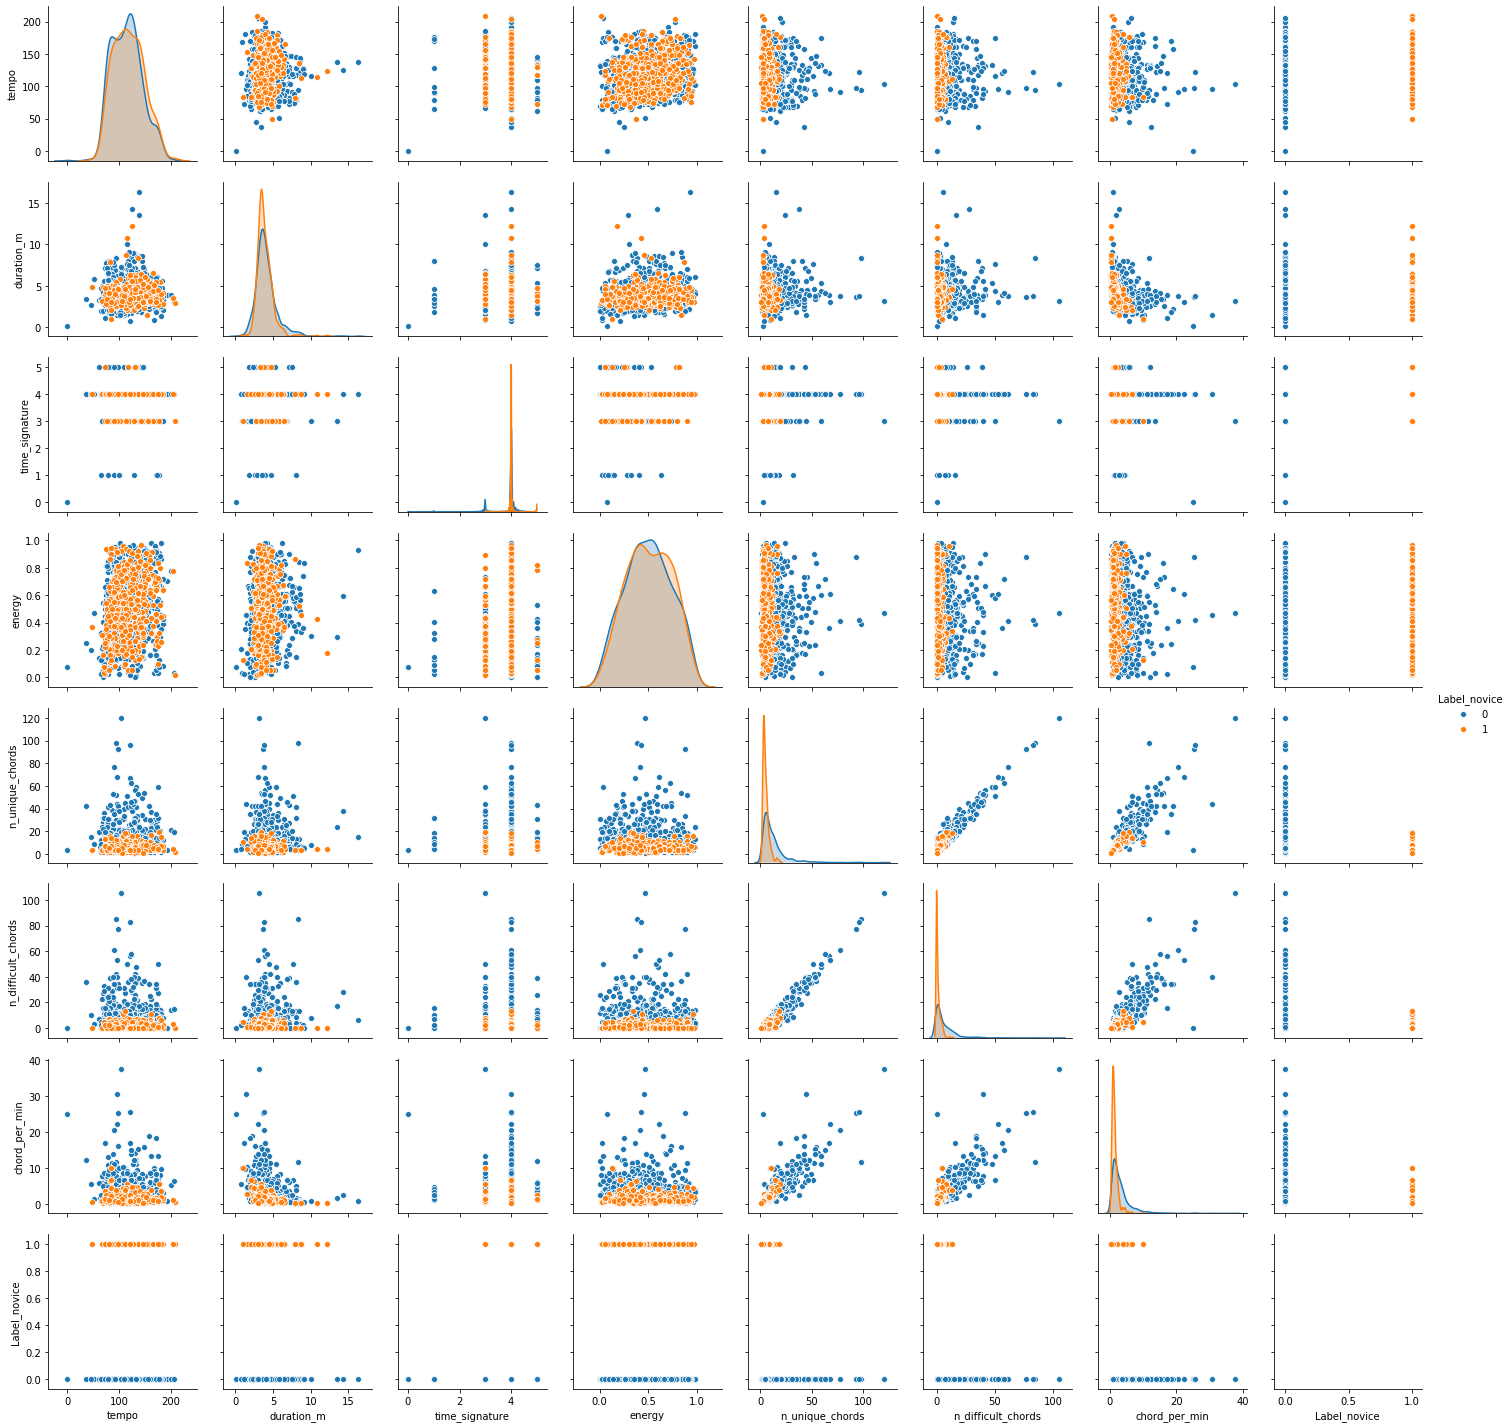

In [35]:
sns.pairplot(featuresNovice, hue='Label_novice')

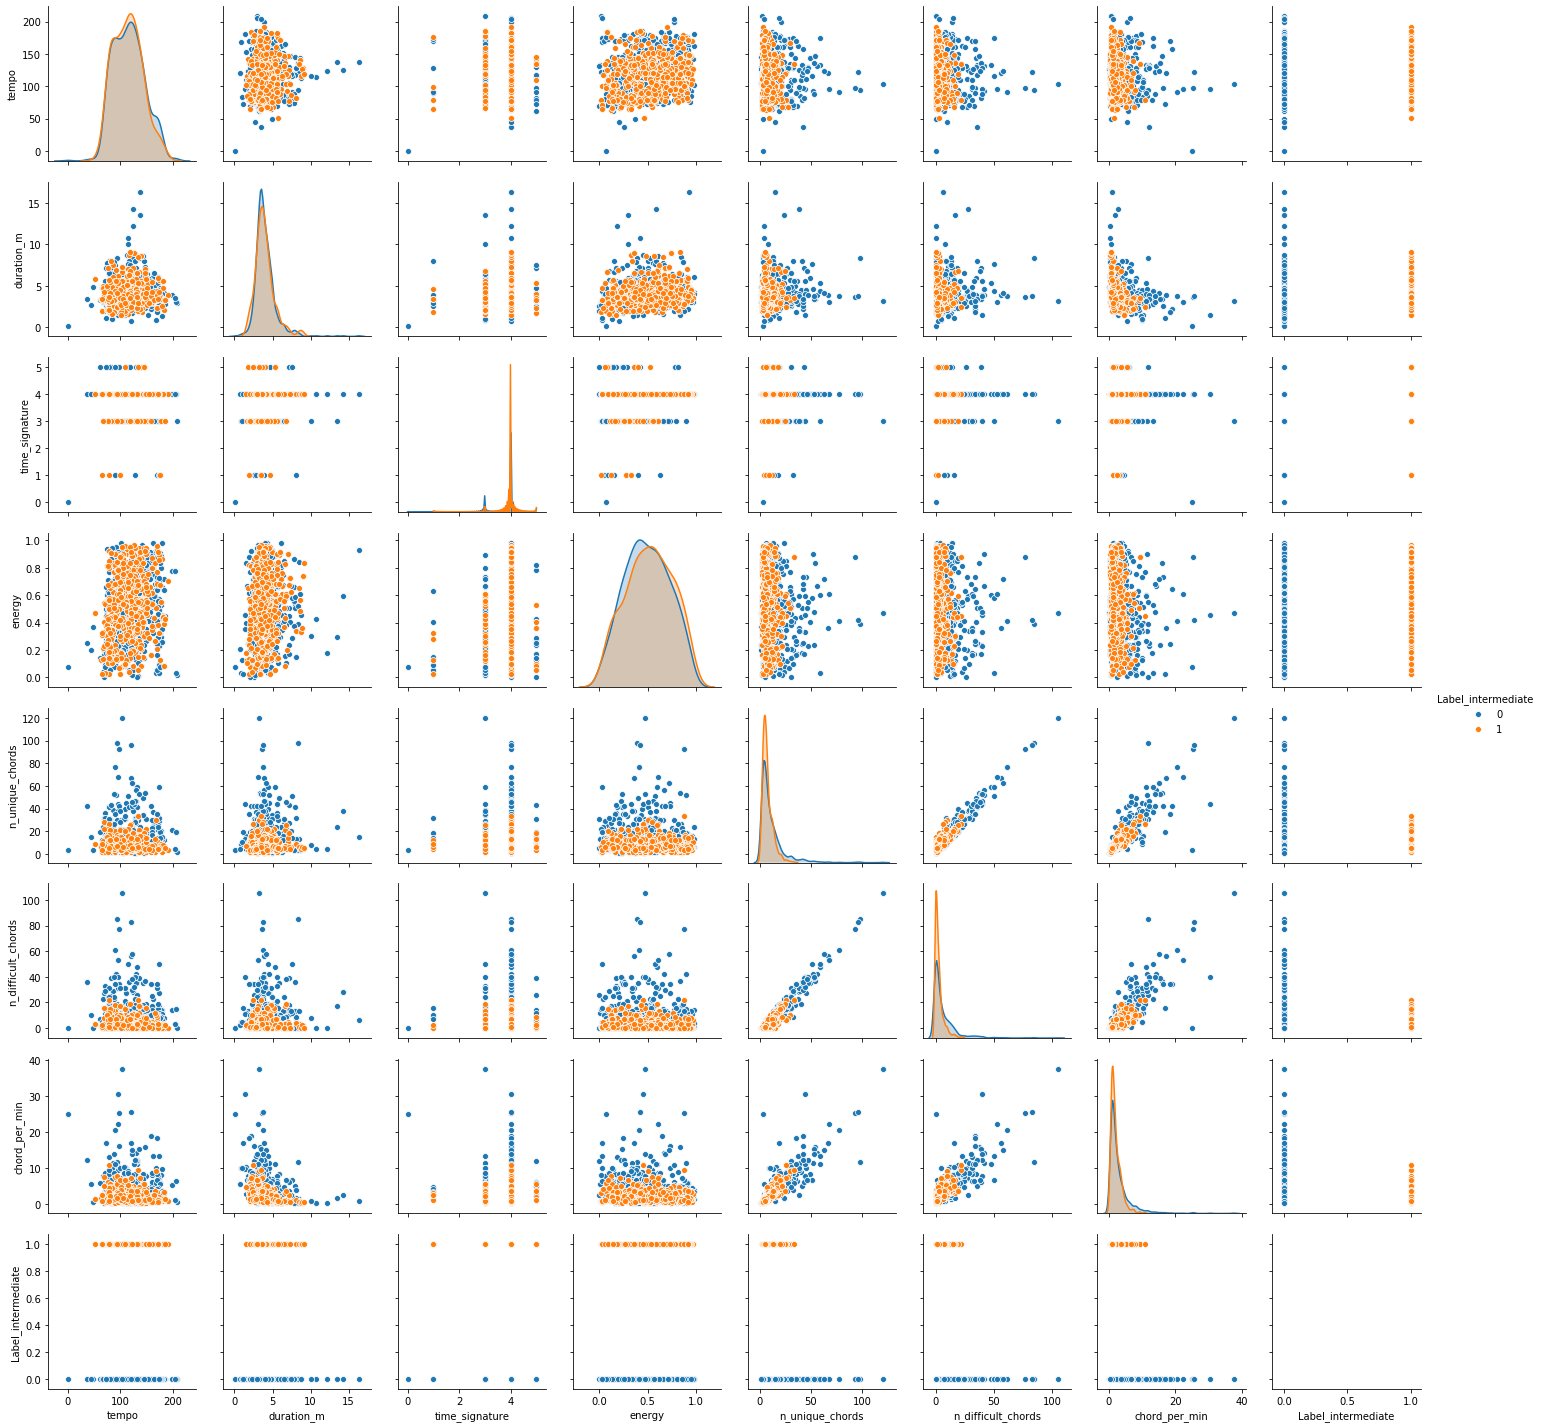

In [36]:
sns.pairplot(featuresInter, hue='Label_intermediate')

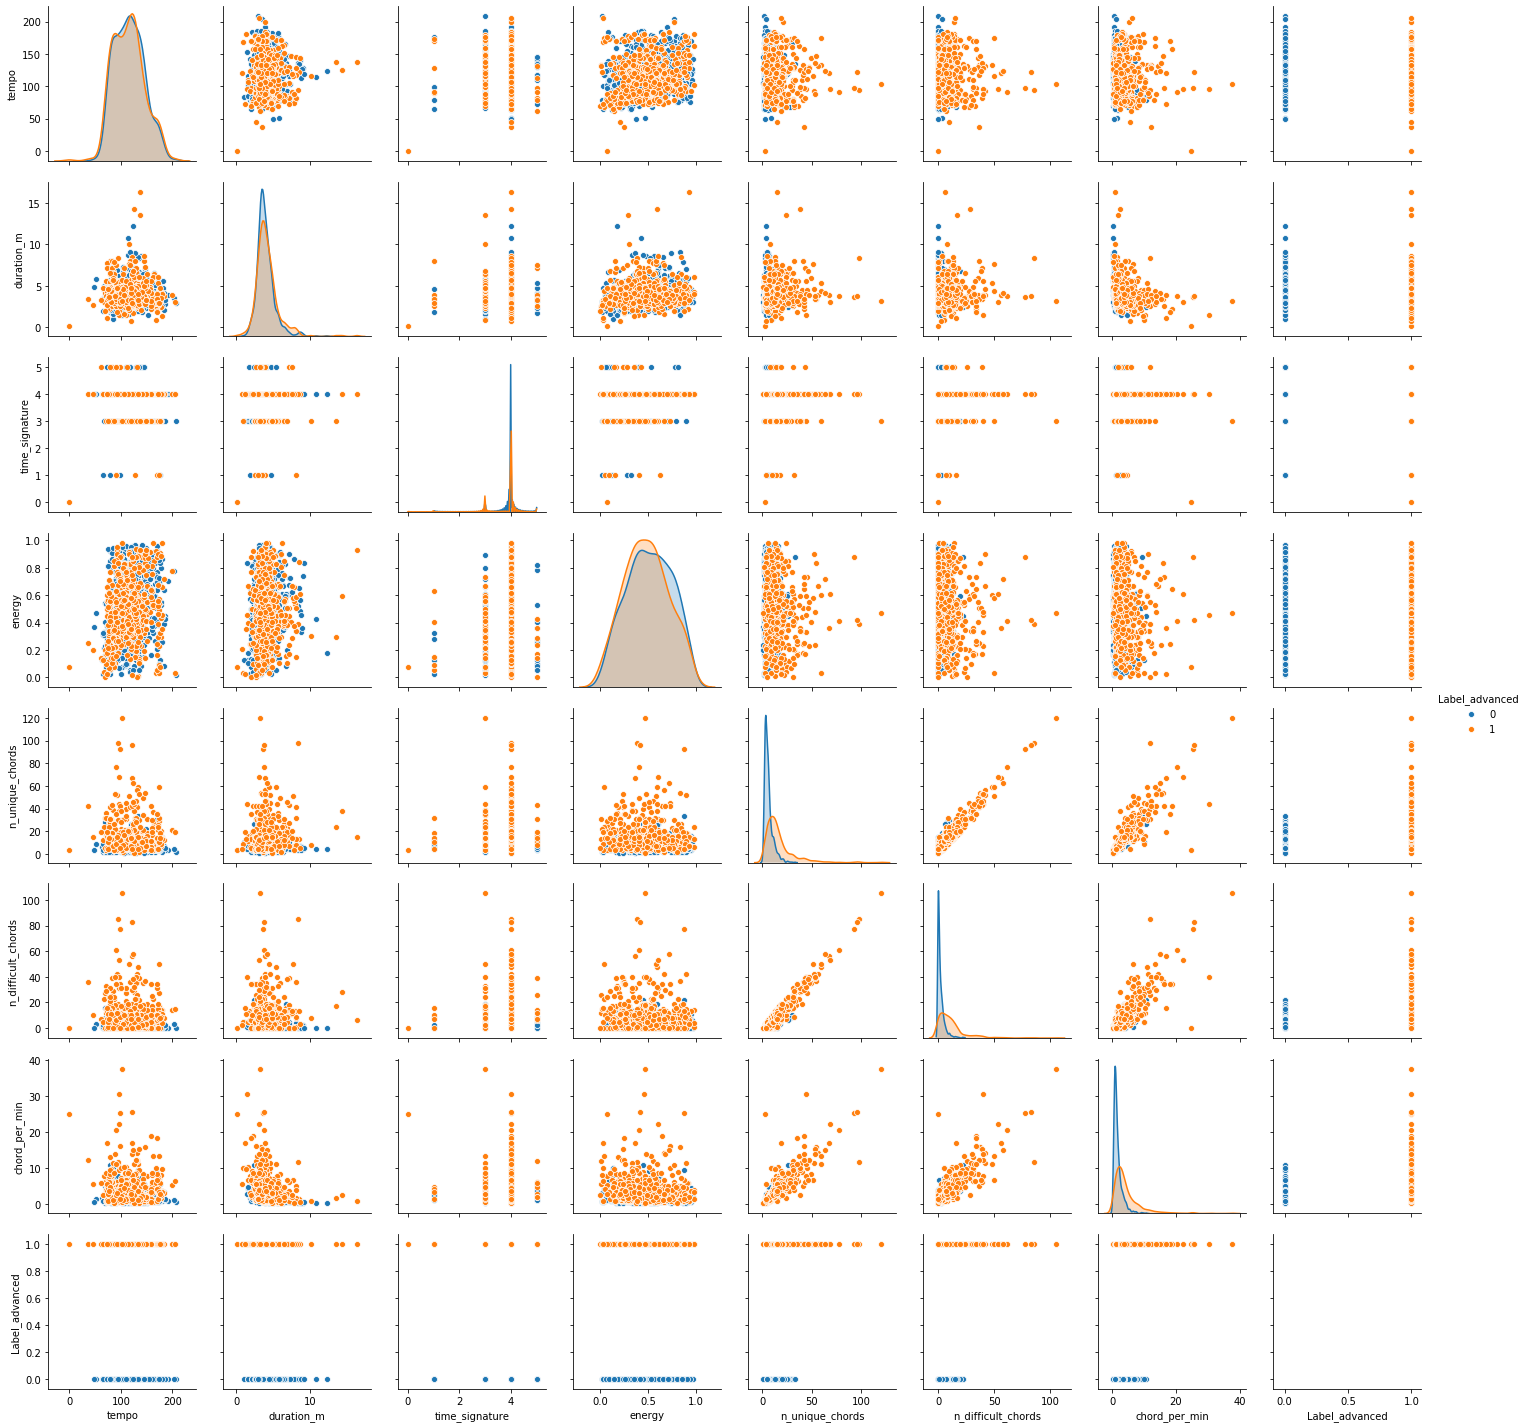

In [37]:
sns.pairplot(featuresAdv, hue='Label_advanced')

In [7]:
small_adv = featuresAdv[featuresAdv['Label_advanced']==1]['n_unique_chords']<=3 
small_adv_ix = [i for i, x in enumerate(small_adv) if x]
sum(small_adv)

19

In [ ]:
# doesn't look that different when you remove those 19 weirdo songs.
sns.pairplot(testDrop, hue='Label_advanced')

In [59]:
# advanced label
X = featuresAdv.drop(featuresAdv.index[small_adv_ix])
X.dropna(axis=0, how='any', inplace=True)
X.reset_index(drop=True)

y = X['Label_advanced']
X.drop('Label_advanced', axis=1, inplace=True)

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X)
X_scale = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=10)

lr_model_adv = LogisticRegression()
lr_model_adv.fit(X_train, y_train) 

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
predictions = lr_model_adv.predict(X_test)

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[159  12]
 [ 36  44]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       171
           1       0.79      0.55      0.65        80

    accuracy                           0.81       251
   macro avg       0.80      0.74      0.76       251
weighted avg       0.81      0.81      0.80       251



In [63]:
pd.DataFrame(lr_model_adv.coef_, columns=X.columns)

,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min
0,-0.056738,0.302341,-0.101157,0.138828,0.220777,1.794273,0.539634


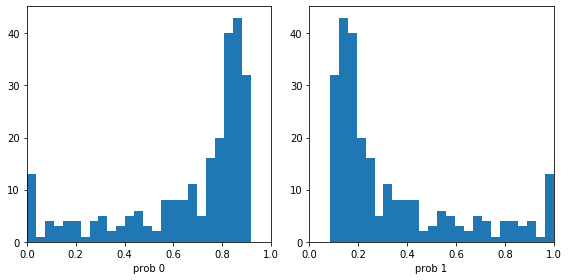

In [64]:
lr_probs=lr_model_adv.predict_proba(X_test)
# lr_probs[:,1]

import matplotlib.pyplot as plt
%matplotlib inline 

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].hist(lr_probs[:,0], bins=25)
ax[0].set_xlabel('prob 0')
ax[0].set_xlim(0,1)

ax[1].hist(lr_probs[:,1], bins=25)
ax[1].set_xlabel('prob 1')
ax[1].set_xlim(0,1)


plt.tight_layout()

Text(0, 0.5, 'confidence')

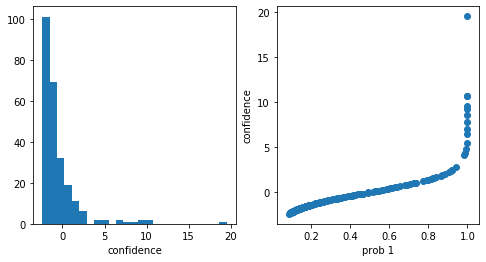

In [65]:
lr_confidence = lr_model_adv.decision_function(X_test)
# lr_confidence

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].hist(lr_confidence, bins=25)
ax[0].set_xlabel('confidence')

ax[1].scatter(lr_probs[:,1], lr_confidence)
ax[1].set_xlabel('prob 1')
ax[1].set_ylabel('confidence')
# ax[1].set_xlim(0,1)

# plt.tight_layout()

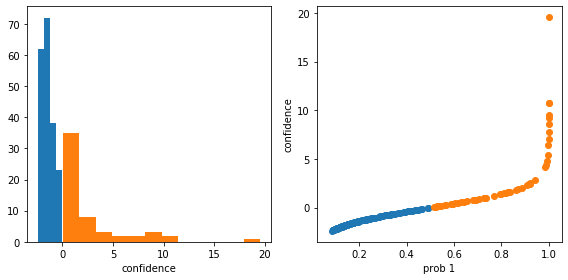

In [66]:
lr_probs = lr_model_adv.predict_proba(X_test)
lr_confidence = lr_model_adv.decision_function(X_test)
# lr_confidence

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].hist(lr_confidence[predictions==0], bins=4)
ax[0].hist(lr_confidence[predictions==1], bins=12)
ax[0].set_xlabel('confidence')

ax[1].scatter(lr_probs[predictions==0,1], lr_confidence[predictions==0])
ax[1].scatter(lr_probs[predictions==1,1], lr_confidence[predictions==1])

ax[1].set_xlabel('prob 1')
ax[1].set_ylabel('confidence')
# ax[1].set_xlim(0,1)

plt.tight_layout()

In [65]:
# import pickle
# # save the model to disk
# filename = 'lr_adv_model_0930.sav'
# pickle.dump(lr_model_adv, open(filename, 'wb'))

In [45]:
# try a random forest instead.
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

tree_pred = dtree.predict(X_test)

print(confusion_matrix(y_test, tree_pred))
print(classification_report(y_test, tree_pred))

[[128  31]
 [ 37  54]]
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       159
           1       0.64      0.59      0.61        91

    accuracy                           0.73       250
   macro avg       0.71      0.70      0.70       250
weighted avg       0.72      0.73      0.73       250



In [67]:
# novice label
X = featuresNovice.drop(featuresNovice.index[small_adv_ix])
X.reset_index(drop=True, inplace=True)

# X.dropna(axis=0, how='any', inplace=True)
# X.reset_index(drop=True, inplace=True)

y = X['Label_novice']
X.drop('Label_novice', axis=1, inplace=True)

In [68]:
scaler.fit(X)
X_scale = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lr_model_nov = LogisticRegression()
lr_model_nov.fit(X_train, y_train) 

predictions = lr_model_nov.predict(X_test)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[152  26]
 [ 36  37]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       178
           1       0.59      0.51      0.54        73

    accuracy                           0.75       251
   macro avg       0.70      0.68      0.69       251
weighted avg       0.74      0.75      0.75       251



In [70]:
pd.DataFrame(lr_model_nov.coef_, columns=X_train.columns)


,tempo,duration_m,time_signature,energy,n_unique_chords,n_difficult_chords,chord_per_min
0,0.005106,-0.108821,0.050552,-0.472439,-0.125987,-0.117421,-0.112858


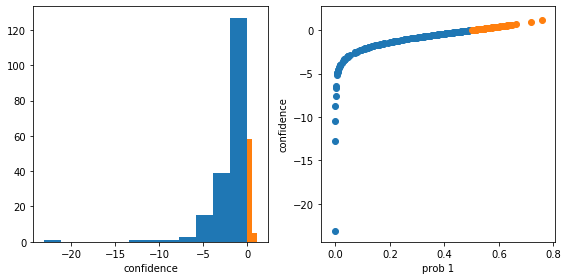

In [71]:
lr_probs = lr_model_nov.predict_proba(X_test)
lr_confidence = lr_model_nov.decision_function(X_test)

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].hist(lr_confidence[predictions==0], bins=12)
ax[0].hist(lr_confidence[predictions==1], bins=2)
ax[0].set_xlabel('confidence')

ax[1].scatter(lr_probs[predictions==0,1], lr_confidence[predictions==0])
ax[1].scatter(lr_probs[predictions==1,1], lr_confidence[predictions==1])

ax[1].set_xlabel('prob 1')
ax[1].set_ylabel('confidence')
# ax[1].set_xlim(0,1)

plt.tight_layout()